In [1]:
import pyspark
import pandas as pd

# load in the merged dataframe, containing GDSC1, GDSC2, and cell line metadata
gdsc_merged = pd.read_csv("GDSC1and2_w_CellLineData.csv")
df = gdsc_merged
gdsc_merged.head(5)

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,...,LN_IC50,AUC,RMSE,Z_SCORE,Sample Name,GDSC_Tissue_descriptor_1,GDSC_Tissue_descriptor_2,Cancer_Type_TCGA,Medium,Growth
0,GDSC1,342,15580432,684057,ES5,SIDM00263,UNCLASSIFIED,1,Erlotinib,EGFR,...,3.966813,0.985678,0.026081,1.299144,ES5,bone,ewings_sarcoma,NaN,R,Adherent
1,GDSC1,342,15580806,684059,ES7,SIDM00269,UNCLASSIFIED,1,Erlotinib,EGFR,...,2.692090,0.972690,0.110059,0.156076,ES7,bone,ewings_sarcoma,NaN,R,Adherent
2,GDSC1,342,15581198,684062,EW-11,SIDM00203,UNCLASSIFIED,1,Erlotinib,EGFR,...,2.477990,0.944459,0.087019,-0.035912,EW-11,bone,ewings_sarcoma,NaN,R,Adherent
3,GDSC1,342,15581542,684072,SK-ES-1,SIDM01111,UNCLASSIFIED,1,Erlotinib,EGFR,...,2.033564,0.950758,0.016290,-0.434437,SK-ES-1,bone,ewings_sarcoma,NaN,R,Semi-Adherent
4,GDSC1,342,15581930,687448,COLO-829,SIDM00909,SKCM,1,Erlotinib,EGFR,...,2.966007,0.954778,0.180255,0.401702,COLO-829,skin,melanoma,SKCM,R,Adherent


In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[["z_LN_IC50", "z_AUC"]] = scaler.fit_transform(df[["LN_IC50", "AUC"]])

# For interpretability: low LN_IC50 = sensitive, low AUC = sensitive
df["z_IC50_sens"] = df["z_LN_IC50"]


# Sensitivity (average of both)
df["sensitivity"] = (df["z_IC50_sens"] + df["z_AUC"]) / 2

# Disagreement (difference between metrics)
df["disagreement"] = df["z_AUC"] - df["z_IC50_sens"]


# Weighted averages of both metrics for different α
alphas = [0.25, 0.5, 0.75]
for a in alphas:
    df[f"y_weighted_{a}"] = a * df["z_IC50_sens"] + (1 - a) * df["z_AUC"]

df.head(5)

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,...,Medium,Growth,z_LN_IC50,z_AUC,z_IC50_sens,sensitivity,disagreement,y_weighted_0.25,y_weighted_0.5,y_weighted_0.75
0,GDSC1,342,15580432,684057,ES5,SIDM00263,UNCLASSIFIED,1,Erlotinib,EGFR,...,R,Adherent,0.587657,0.738863,0.587657,0.663260,0.151206,0.701061,0.663260,0.625459
1,GDSC1,342,15580806,684059,ES7,SIDM00269,UNCLASSIFIED,1,Erlotinib,EGFR,...,R,Adherent,0.113887,0.665612,0.113887,0.389749,0.551725,0.527680,0.389749,0.251818
2,GDSC1,342,15581198,684062,EW-11,SIDM00203,UNCLASSIFIED,1,Erlotinib,EGFR,...,R,Adherent,0.034313,0.506391,0.034313,0.270352,0.472078,0.388372,0.270352,0.152333
3,GDSC1,342,15581542,684072,SK-ES-1,SIDM01111,UNCLASSIFIED,1,Erlotinib,EGFR,...,R,Semi-Adherent,-0.130864,0.541917,-0.130864,0.205526,0.672781,0.373722,0.205526,0.037331
4,GDSC1,342,15581930,687448,COLO-829,SIDM00909,SKCM,1,Erlotinib,EGFR,...,R,Adherent,0.215692,0.564589,0.215692,0.390141,0.348897,0.477365,0.390141,0.302917


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def random_split(df, test_size=0.2, random_state=42):
    """
    Completely random splitting.
    """
    return train_test_split(df, test_size=test_size, random_state=random_state, shuffle=True)

def unseen_cell_lines_split(df, test_size=0.2, random_state=42):
    """
    Splits dataset so that cell lines in test are unseen in train.
    """
    cell_lines = df['COSMIC_ID'].unique()
    train_lines, test_lines = train_test_split(cell_lines, test_size=test_size, random_state=random_state)
    train_df = df[df['COSMIC_ID'].isin(train_lines)]
    test_df = df[df['COSMIC_ID'].isin(test_lines)]
    return train_df, test_df

def unseen_drugs_split(df, test_size=0.2, random_state=42):
    """
    Splits dataset so that drugs in test are unseen in train.
    """
    drugs = df['DRUG_ID'].unique()
    train_drugs, test_drugs = train_test_split(drugs, test_size=test_size, random_state=random_state)
    train_df = df[df['DRUG_ID'].isin(train_drugs)]
    test_df = df[df['DRUG_ID'].isin(test_drugs)]
    return train_df, test_df

def unseen_cell_line_drug_pairs_split(df, test_size=0.2, random_state=42):
    """
    Creates disjoint sets of both drugs and cell lines.
    Test set contains combinations of unseen drugs and unseen cell lines.
    """
    drugs = df['DRUG_ID'].unique()
    cell_lines = df['COSMIC_ID'].unique()

    # Select subsets of drugs and cell lines for the test set
    test_drugs = np.random.default_rng(random_state).choice(drugs, size=int(len(drugs) * test_size), replace=False)
    test_cells = np.random.default_rng(random_state + 1).choice(cell_lines, size=int(len(cell_lines) * test_size), replace=False)

    # Test = only pairs where BOTH drug and cell line are unseen
    test_df = df[(df['DRUG_ID'].isin(test_drugs)) & (df['COSMIC_ID'].isin(test_cells))]

    # Train = everything else (ensures no leakage)
    train_df = df[~df.index.isin(test_df.index)]

    return train_df, test_df

Model Training - Random Forest prediction of z_ln_ic50

In [14]:
# Traing test split randomly
train_df_random, test_df_random = random_split(df)

In [15]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode categorical variables (DRUG_ID and COSMIC_ID)
# drug_encoder = LabelEncoder()
# cell_encoder = LabelEncoder()

# train_df_random['DRUG_ID_encoded'] = drug_encoder.fit_transform(train_df_random['DRUG_ID'])
# train_df_random['COSMIC_ID_encoded'] = cell_encoder.fit_transform(train_df_random['COSMIC_ID'])

# test_df_random['DRUG_ID_encoded'] = test_df_random['DRUG_ID'].map(
#     dict(zip(drug_encoder.classes_, drug_encoder.transform(drug_encoder.classes_)))
# ).fillna(-1).astype(int)

# test_df_random['COSMIC_ID_encoded'] = test_df_random['COSMIC_ID'].map(
#     dict(zip(cell_encoder.classes_, cell_encoder.transform(cell_encoder.classes_)))
# ).fillna(-1).astype(int)

# Prepare features and target
X_train = train_df_random[['DRUG_ID', 'COSMIC_ID']]
y_train = train_df_random['z_LN_IC50']

X_test = test_df_random[['DRUG_ID', 'COSMIC_ID']]
y_test = test_df_random['z_LN_IC50']

Performing Grid Search for Random Forest hyperparameters...
This may take a few minutes...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best parameters found:
  max_depth: 20
  n_estimators: 200

Best cross-validation RMSE: 0.5430
Random Forest Model Performance:
Train RMSE: 0.4705
Test RMSE: 0.5395
Train R²: 0.7787
Test R²: 0.7084

Feature Importance:
     feature  importance
0    DRUG_ID     0.90111
1  COSMIC_ID     0.09889


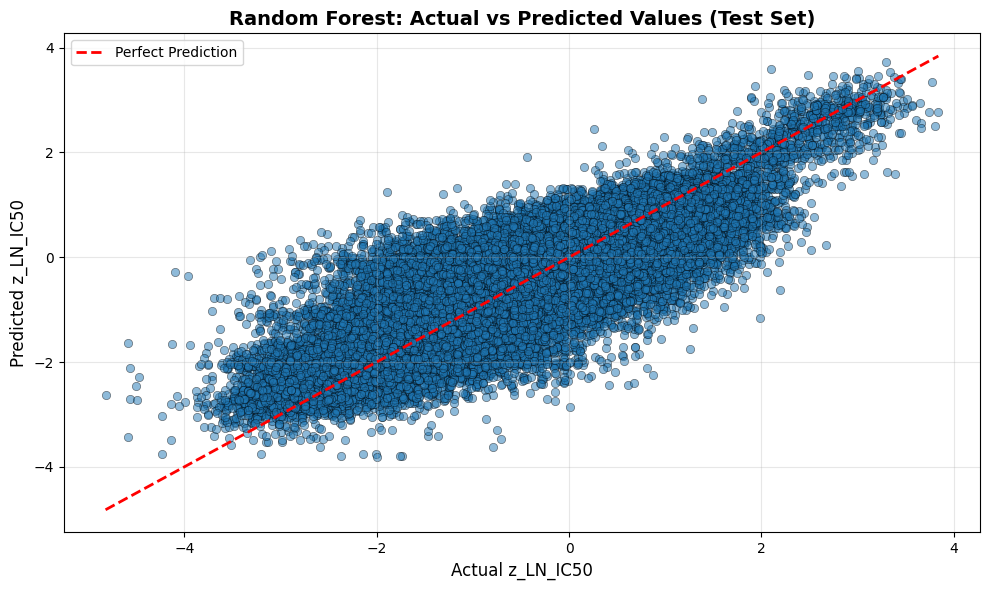


Residuals Statistics:
Mean Residual: 0.0030
Std Residual: 0.5395
Min Residual: -3.8233
Max Residual: 3.1417


In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, 20, None]
}

# Create Random Forest model
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# Perform Grid Search with cross-validation
print("Performing Grid Search for Random Forest hyperparameters...")
print("This may take a few minutes...")

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Print best parameters
print(f"\nBest parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

# Use the best model
rf_model = grid_search.best_estimator_

# Make predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Evaluate model
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
train_r2_rf = r2_score(y_train, y_train_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)

print("Random Forest Model Performance:")
print(f"Train RMSE: {train_rmse_rf:.4f}")
print(f"Test RMSE: {test_rmse_rf:.4f}")
print(f"Train R²: {train_r2_rf:.4f}")
print(f"Test R²: {test_r2_rf:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': ['DRUG_ID', 'COSMIC_ID'],
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
print(f"\nFeature Importance:")
print(feature_importance)

# Create scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_rf, alpha=0.5, edgecolors='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual z_LN_IC50', fontsize=12)
plt.ylabel('Predicted z_LN_IC50', fontsize=12)
plt.title('Random Forest: Actual vs Predicted Values (Test Set)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print additional statistics
residuals_rf = y_test - y_test_pred_rf
print(f"\nResiduals Statistics:")
print(f"Mean Residual: {residuals_rf.mean():.4f}")
print(f"Std Residual: {residuals_rf.std():.4f}")
print(f"Min Residual: {residuals_rf.min():.4f}")
print(f"Max Residual: {residuals_rf.max():.4f}")

In [17]:
import joblib

joblib.dump(rf_model, 'rf_ic50.pkl')
# joblib.dump(drug_encoder, 'drug_encoder.pkl')
# joblib.dump(cell_encoder, 'cell_encoder.pkl')

['rf_ic50.pkl']

z_AUC prediction

In [18]:
y_train_auc = train_df_random['z_AUC']
y_test_auc = test_df_random['z_AUC']

print(f"Training samples: {len(y_train_auc)}")
print(f"Test samples: {len(y_test_auc)}")

Training samples: 460157
Test samples: 115040


Fitting 3 folds for each of 15 candidates, totalling 45 fits


Best params: {'max_depth': 20, 'n_estimators': 200}
Best CV RMSE: 0.6743
Random Forest (z_AUC):
Train RMSE: 0.5315, Test RMSE: 0.6664
Train R²: 0.7175, Test R²: 0.5560


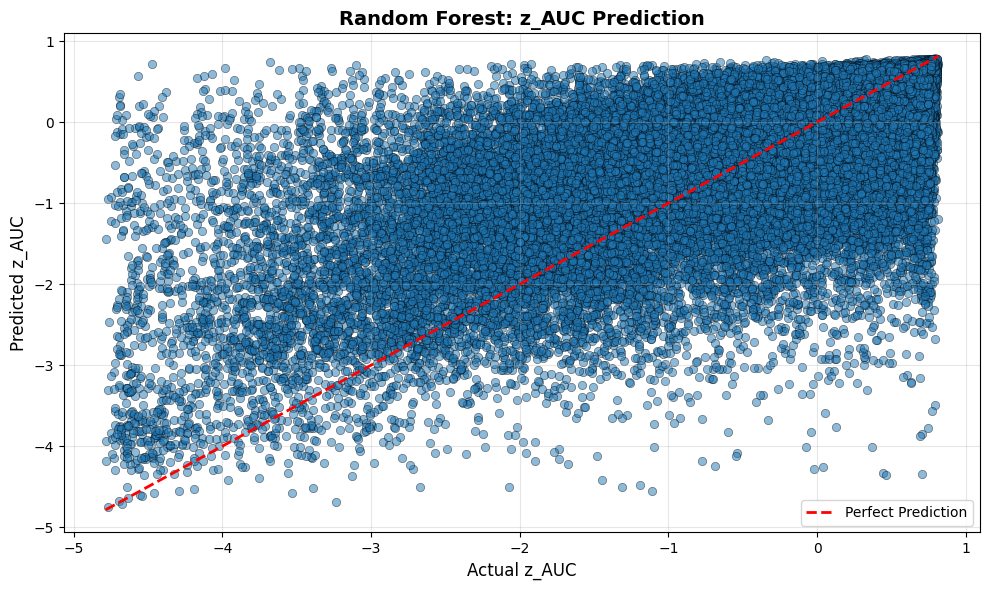

In [19]:
# Random Forest for z_AUC
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, 20, None]
}

rf_base_auc = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search_rf_auc = GridSearchCV(rf_base_auc, param_grid_rf, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search_rf_auc.fit(X_train, y_train_auc)

print(f"Best params: {grid_search_rf_auc.best_params_}")
print(f"Best CV RMSE: {np.sqrt(-grid_search_rf_auc.best_score_):.4f}")

rf_model_auc = grid_search_rf_auc.best_estimator_
y_train_pred_rf_auc = rf_model_auc.predict(X_train)
y_test_pred_rf_auc = rf_model_auc.predict(X_test)

train_rmse_rf_auc = np.sqrt(mean_squared_error(y_train_auc, y_train_pred_rf_auc))
test_rmse_rf_auc = np.sqrt(mean_squared_error(y_test_auc, y_test_pred_rf_auc))
train_r2_rf_auc = r2_score(y_train_auc, y_train_pred_rf_auc)
test_r2_rf_auc = r2_score(y_test_auc, y_test_pred_rf_auc)

print("Random Forest (z_AUC):")
print(f"Train RMSE: {train_rmse_rf_auc:.4f}, Test RMSE: {test_rmse_rf_auc:.4f}")
print(f"Train R²: {train_r2_rf_auc:.4f}, Test R²: {test_r2_rf_auc:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test_auc, y_test_pred_rf_auc, alpha=0.5, edgecolors='k', linewidth=0.5)
plt.plot([y_test_auc.min(), y_test_auc.max()], [y_test_auc.min(), y_test_auc.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual z_AUC', fontsize=12)
plt.ylabel('Predicted z_AUC', fontsize=12)
plt.title('Random Forest: z_AUC Prediction', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:
joblib.dump(rf_model_auc, 'rf_auc.pkl')

['rf_auc.pkl']